# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy import optimize

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma=1
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        self.trees = []
        y_new = y
        for i in range(self.n_estimators):
            self.trees.append(DecisionTreeRegressor(max_depth = self.max_depth))
            y_tree = self._fit_predict_tree(x, y_new)
            y_new = y_new - y_tree

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = self.trees[-1]
        tree.fit(x, y)
        fun = lambda t: mean_squared_error(y, t * tree.predict(x))
        self.gamma = optimize.minimize_scalar(fun)['x']
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.zeros(x.shape[0])
        for i in range(self.n_estimators):
            tree = self.trees[i]
            y_tree = self.gamma * self.learning_rate * tree.predict(x)
            y_pred += y_tree
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [6]:
np.random.seed(19052019)
gb = GradientBoosting(400, 6, 0.03580000929949099)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred)

9.619836009722205

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да 

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [7]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [8]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [9]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

C:\Users\lenas\anaconda3\anaconda33\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7015741427151587

In [10]:
from catboost import CatBoostClassifier

X_train = train.drop(columns=['dep_delayed_15min'])
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

cat_model = CatBoostClassifier(cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'])
cat_model.fit(X_train_part, y_train_part)

Learning rate set to 0.063211
0:	learn: 0.6606730	total: 376ms	remaining: 6m 15s
1:	learn: 0.6333274	total: 498ms	remaining: 4m 8s
2:	learn: 0.6087510	total: 630ms	remaining: 3m 29s
3:	learn: 0.5890346	total: 702ms	remaining: 2m 54s
4:	learn: 0.5722791	total: 765ms	remaining: 2m 32s
5:	learn: 0.5556376	total: 901ms	remaining: 2m 29s
6:	learn: 0.5421690	total: 997ms	remaining: 2m 21s
7:	learn: 0.5294192	total: 1.12s	remaining: 2m 19s
8:	learn: 0.5199410	total: 1.18s	remaining: 2m 9s
9:	learn: 0.5107531	total: 1.31s	remaining: 2m 9s
10:	learn: 0.5032507	total: 1.44s	remaining: 2m 9s
11:	learn: 0.4968468	total: 1.51s	remaining: 2m 4s
12:	learn: 0.4909254	total: 1.66s	remaining: 2m 5s
13:	learn: 0.4849591	total: 1.82s	remaining: 2m 8s
14:	learn: 0.4817900	total: 1.85s	remaining: 2m 1s
15:	learn: 0.4771753	total: 1.99s	remaining: 2m 2s
16:	learn: 0.4728848	total: 2.14s	remaining: 2m 3s
17:	learn: 0.4700037	total: 2.27s	remaining: 2m 3s
18:	learn: 0.4669753	total: 2.42s	remaining: 2m 5s
19:	

159:	learn: 0.4203365	total: 23.8s	remaining: 2m 5s
160:	learn: 0.4203097	total: 24s	remaining: 2m 5s
161:	learn: 0.4202368	total: 24.1s	remaining: 2m 4s
162:	learn: 0.4201750	total: 24.3s	remaining: 2m 4s
163:	learn: 0.4201302	total: 24.4s	remaining: 2m 4s
164:	learn: 0.4200597	total: 24.6s	remaining: 2m 4s
165:	learn: 0.4199917	total: 24.7s	remaining: 2m 4s
166:	learn: 0.4199617	total: 24.9s	remaining: 2m 4s
167:	learn: 0.4198859	total: 25s	remaining: 2m 3s
168:	learn: 0.4197995	total: 25.1s	remaining: 2m 3s
169:	learn: 0.4197247	total: 25.3s	remaining: 2m 3s
170:	learn: 0.4196458	total: 25.4s	remaining: 2m 3s
171:	learn: 0.4195917	total: 25.5s	remaining: 2m 2s
172:	learn: 0.4194922	total: 25.7s	remaining: 2m 2s
173:	learn: 0.4194187	total: 25.8s	remaining: 2m 2s
174:	learn: 0.4192953	total: 26s	remaining: 2m 2s
175:	learn: 0.4192162	total: 26.1s	remaining: 2m 2s
176:	learn: 0.4191771	total: 26.2s	remaining: 2m 2s
177:	learn: 0.4191376	total: 26.4s	remaining: 2m 2s
178:	learn: 0.4190

317:	learn: 0.4104685	total: 46.6s	remaining: 1m 39s
318:	learn: 0.4104365	total: 46.8s	remaining: 1m 39s
319:	learn: 0.4104167	total: 47s	remaining: 1m 39s
320:	learn: 0.4103782	total: 47.1s	remaining: 1m 39s
321:	learn: 0.4103331	total: 47.3s	remaining: 1m 39s
322:	learn: 0.4103017	total: 47.4s	remaining: 1m 39s
323:	learn: 0.4102377	total: 47.5s	remaining: 1m 39s
324:	learn: 0.4101437	total: 47.7s	remaining: 1m 38s
325:	learn: 0.4101062	total: 47.8s	remaining: 1m 38s
326:	learn: 0.4100818	total: 47.9s	remaining: 1m 38s
327:	learn: 0.4100535	total: 48.1s	remaining: 1m 38s
328:	learn: 0.4099481	total: 48.2s	remaining: 1m 38s
329:	learn: 0.4099270	total: 48.4s	remaining: 1m 38s
330:	learn: 0.4098688	total: 48.5s	remaining: 1m 38s
331:	learn: 0.4098012	total: 48.7s	remaining: 1m 37s
332:	learn: 0.4097541	total: 48.8s	remaining: 1m 37s
333:	learn: 0.4096819	total: 48.9s	remaining: 1m 37s
334:	learn: 0.4096634	total: 49.1s	remaining: 1m 37s
335:	learn: 0.4096271	total: 49.2s	remaining: 1m

473:	learn: 0.4042880	total: 1m 8s	remaining: 1m 15s
474:	learn: 0.4042695	total: 1m 8s	remaining: 1m 15s
475:	learn: 0.4042478	total: 1m 8s	remaining: 1m 15s
476:	learn: 0.4041846	total: 1m 8s	remaining: 1m 15s
477:	learn: 0.4041389	total: 1m 8s	remaining: 1m 15s
478:	learn: 0.4040893	total: 1m 9s	remaining: 1m 15s
479:	learn: 0.4040511	total: 1m 9s	remaining: 1m 15s
480:	learn: 0.4040254	total: 1m 9s	remaining: 1m 14s
481:	learn: 0.4040038	total: 1m 9s	remaining: 1m 14s
482:	learn: 0.4039552	total: 1m 9s	remaining: 1m 14s
483:	learn: 0.4039210	total: 1m 9s	remaining: 1m 14s
484:	learn: 0.4038990	total: 1m 9s	remaining: 1m 14s
485:	learn: 0.4038581	total: 1m 10s	remaining: 1m 14s
486:	learn: 0.4038156	total: 1m 10s	remaining: 1m 13s
487:	learn: 0.4038007	total: 1m 10s	remaining: 1m 13s
488:	learn: 0.4037284	total: 1m 10s	remaining: 1m 13s
489:	learn: 0.4036717	total: 1m 10s	remaining: 1m 13s
490:	learn: 0.4036522	total: 1m 10s	remaining: 1m 13s
491:	learn: 0.4036243	total: 1m 10s	rema

629:	learn: 0.3988405	total: 1m 30s	remaining: 53s
630:	learn: 0.3988132	total: 1m 30s	remaining: 52.9s
631:	learn: 0.3987600	total: 1m 30s	remaining: 52.7s
632:	learn: 0.3987274	total: 1m 30s	remaining: 52.6s
633:	learn: 0.3986625	total: 1m 30s	remaining: 52.4s
634:	learn: 0.3986384	total: 1m 30s	remaining: 52.3s
635:	learn: 0.3986080	total: 1m 31s	remaining: 52.1s
636:	learn: 0.3985829	total: 1m 31s	remaining: 52s
637:	learn: 0.3984948	total: 1m 31s	remaining: 51.8s
638:	learn: 0.3984468	total: 1m 31s	remaining: 51.7s
639:	learn: 0.3984161	total: 1m 31s	remaining: 51.6s
640:	learn: 0.3983743	total: 1m 31s	remaining: 51.4s
641:	learn: 0.3983569	total: 1m 31s	remaining: 51.3s
642:	learn: 0.3983295	total: 1m 32s	remaining: 51.1s
643:	learn: 0.3983038	total: 1m 32s	remaining: 51s
644:	learn: 0.3982643	total: 1m 32s	remaining: 50.8s
645:	learn: 0.3982209	total: 1m 32s	remaining: 50.7s
646:	learn: 0.3981862	total: 1m 32s	remaining: 50.6s
647:	learn: 0.3981564	total: 1m 32s	remaining: 50.4s

785:	learn: 0.3935648	total: 1m 51s	remaining: 30.5s
786:	learn: 0.3935505	total: 1m 52s	remaining: 30.3s
787:	learn: 0.3935364	total: 1m 52s	remaining: 30.2s
788:	learn: 0.3935213	total: 1m 52s	remaining: 30.1s
789:	learn: 0.3934739	total: 1m 52s	remaining: 29.9s
790:	learn: 0.3934635	total: 1m 52s	remaining: 29.8s
791:	learn: 0.3934139	total: 1m 52s	remaining: 29.6s
792:	learn: 0.3933670	total: 1m 52s	remaining: 29.5s
793:	learn: 0.3933451	total: 1m 53s	remaining: 29.3s
794:	learn: 0.3933302	total: 1m 53s	remaining: 29.2s
795:	learn: 0.3933171	total: 1m 53s	remaining: 29.1s
796:	learn: 0.3932719	total: 1m 53s	remaining: 28.9s
797:	learn: 0.3932350	total: 1m 53s	remaining: 28.8s
798:	learn: 0.3931978	total: 1m 53s	remaining: 28.6s
799:	learn: 0.3931434	total: 1m 53s	remaining: 28.5s
800:	learn: 0.3930858	total: 1m 54s	remaining: 28.4s
801:	learn: 0.3930510	total: 1m 54s	remaining: 28.2s
802:	learn: 0.3930310	total: 1m 54s	remaining: 28.1s
803:	learn: 0.3929990	total: 1m 54s	remaining:

942:	learn: 0.3886660	total: 2m 15s	remaining: 8.17s
943:	learn: 0.3886440	total: 2m 15s	remaining: 8.03s
944:	learn: 0.3886136	total: 2m 15s	remaining: 7.88s
945:	learn: 0.3885940	total: 2m 15s	remaining: 7.74s
946:	learn: 0.3885584	total: 2m 15s	remaining: 7.6s
947:	learn: 0.3885076	total: 2m 15s	remaining: 7.45s
948:	learn: 0.3884795	total: 2m 16s	remaining: 7.31s
949:	learn: 0.3884554	total: 2m 16s	remaining: 7.17s
950:	learn: 0.3884058	total: 2m 16s	remaining: 7.03s
951:	learn: 0.3883709	total: 2m 16s	remaining: 6.88s
952:	learn: 0.3883381	total: 2m 16s	remaining: 6.74s
953:	learn: 0.3883139	total: 2m 16s	remaining: 6.59s
954:	learn: 0.3882876	total: 2m 16s	remaining: 6.45s
955:	learn: 0.3882690	total: 2m 17s	remaining: 6.31s
956:	learn: 0.3882490	total: 2m 17s	remaining: 6.16s
957:	learn: 0.3881996	total: 2m 17s	remaining: 6.02s
958:	learn: 0.3881488	total: 2m 17s	remaining: 5.88s
959:	learn: 0.3881199	total: 2m 17s	remaining: 5.73s
960:	learn: 0.3880950	total: 2m 17s	remaining: 

In [11]:
roc_auc_score(y_valid, cat_model.predict_proba(X_valid)[:, 1])

0.7643552172108752

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [12]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [13]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        
    def fit_predict(self, X):
        self.X = X
        self.k = 0
        self.d = np.zeros(len(X))
        for i in range(len(X)):
            if self.d[i] == 0:
                neighbours = self.range_query(i)
                if len(neighbours) < self.min_samples:
                    self.d[i] = -1
                else:
                    self.k += 1
                    self.grow_cluster(i, neighbours)
        return self.d

    def grow_cluster(self, root, neighbours):
        k = self.k
        self.d[root] = k
        j = 0
        while (j < len(neighbours)):
            i = neighbours[j]
            if self.d[i] <= 0:
                self.d[i] = k
                neighbours2 = self.range_query(i)
                if len(neighbours2) >= self.min_samples:
                    neighbours = np.concatenate((neighbours, neighbours2), axis=0)
            j += 1

    def range_query(self, i):
        """Возвращает точки на расстоянии <= eps от X[i]"""
        ans = []
        x = self.X[i]
        for i in range(len(X)):
            t = self.X[i]
            if self.dist(t, x) <= self.eps:
                ans.append(i)
        return np.array(ans)
        
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        return np.linalg.norm(a-b)

Проверим себя на простом примере:

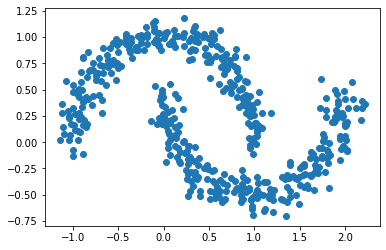

In [14]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

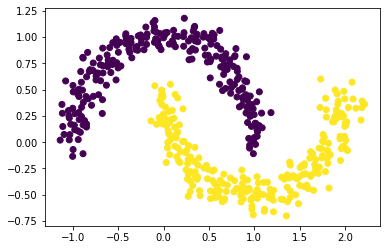

In [15]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

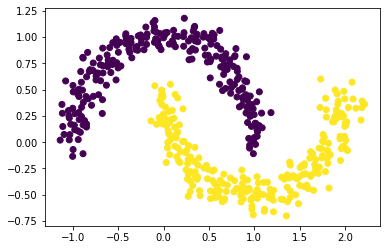

In [16]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

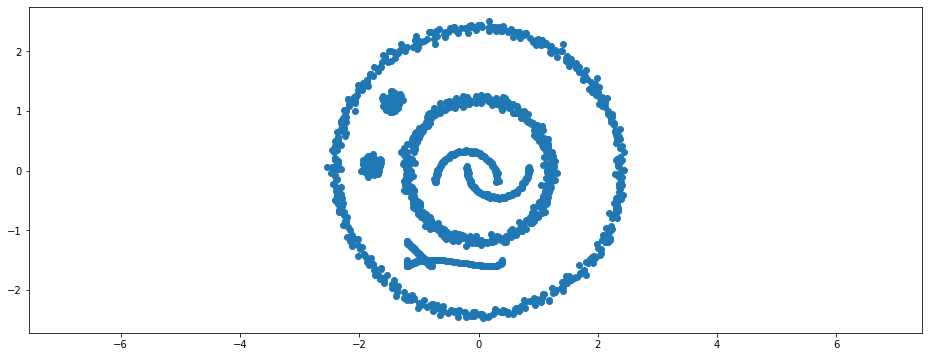

In [22]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
plt.figure(figsize=(16, 6))
X1, _ = make_circles(n_samples=1000, factor=0.5, noise=0.02)
transformation = [[6, 0], [0, 6]]
X1 = np.dot(X1, transformation)
X2, _ = make_moons(n_samples=200, noise=0.01)
transformation = [[2, 0], [0, 2]]
X2 = X2**2 - [3, 4]
X3, _ = make_moons(n_samples=200, noise=0.02)
transformation = [[1.3, 0], [0, 1.3]]
X3 = np.dot(X3, transformation) - 0.5
X4, _ = make_blobs(n_samples=200, centers=2, random_state=178)
transformation = [[1/5, 0], [0, 1/5]]
X4 = np.dot(X4, transformation)+[-4.6, 2]
X = np.concatenate((X1, X2, X3, X4), axis=0)
transformation = [[1/2.5, 0], [0, 1/2.5]]
X = np.dot(X, transformation)
plt.scatter(X[:,0], X[:,1])
plt.axis('equal') 
plt.show()

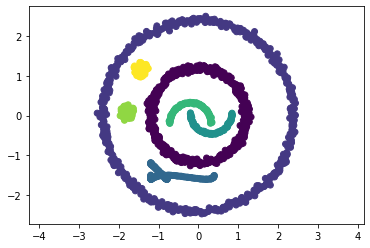

In [23]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.axis('equal') 
plt.show()

Или хотя бы что-нибудь такое: 

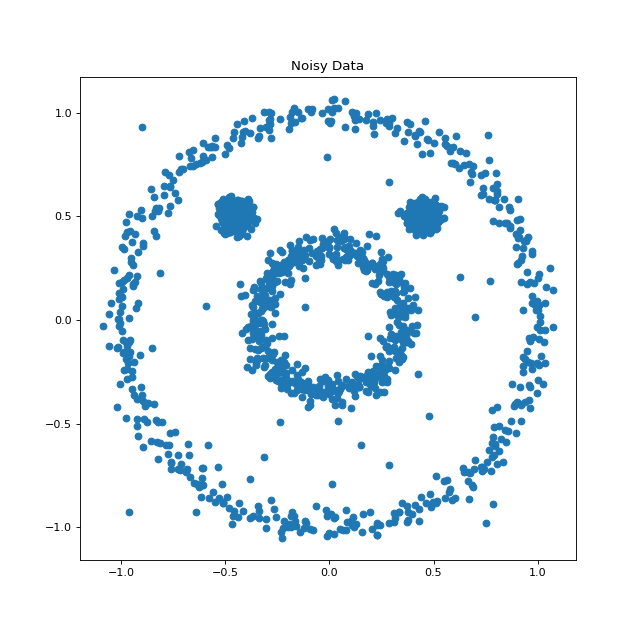

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [24]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 38.7 ms


In [25]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 37.2 s
